## Setup môi trường

In [1]:
# !pip install optuna xgboost scikit-learn

# Tuning mô hình

In [2]:
import optuna
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Load dữ liệu Breast Cancer
data = load_breast_cancer()
X = data.data
y = data.target

/home/tari/.virtualenvs/ner/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(len(X_train), len(X_test))

512 57


In [4]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0,  log=True),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    model = xgb.XGBClassifier(**params, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    return f1

In [5]:
# Tạo một study để tối ưu hóa
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-09-30 10:33:21,443] A new study created in memory with name: no-name-75341596-8e63-435a-8886-b1f3a2e1df3f
[I 2023-09-30 10:33:21,516] Trial 0 finished with value: 0.8247422680412371 and parameters: {'max_depth': 7, 'learning_rate': 0.0484859539777879, 'n_estimators': 93, 'min_child_weight': 7, 'gamma': 0.003887716853212136, 'subsample': 0.06361994275676647, 'colsample_bytree': 0.06782232162947446, 'reg_alpha': 0.006038644041783222, 'reg_lambda': 1.683149290827219e-08}. Best is trial 0 with value: 0.8247422680412371.
[I 2023-09-30 10:33:21,597] Trial 1 finished with value: 0.8247422680412371 and parameters: {'max_depth': 8, 'learning_rate': 0.1656174145846818, 'n_estimators': 179, 'min_child_weight': 8, 'gamma': 0.00010053269099961642, 'subsample': 0.02128568593410314, 'colsample_bytree': 0.4616712115276677, 'reg_alpha': 0.00022891200473432307, 'reg_lambda': 2.859217597337795e-06}. Best is trial 0 with value: 0.8247422680412371.
[I 2023-09-30 10:33:21,708] Trial 2 finished with 

In [6]:
# In ra kết quả tối ưu
print("Kết quả tối ưu:")
print("Tham số tối ưu:", study.best_params)
print("Giá trị mục tiêu tối ưu:", study.best_value)

Kết quả tối ưu:
Tham số tối ưu: {'max_depth': 2, 'learning_rate': 0.1072829131562952, 'n_estimators': 351, 'min_child_weight': 3, 'gamma': 1.2676633674958187e-07, 'subsample': 0.19249842312580015, 'colsample_bytree': 0.2741561403755381, 'reg_alpha': 8.708473290757168e-08, 'reg_lambda': 6.991201461189605e-06}
Giá trị mục tiêu tối ưu: 0.9876543209876543


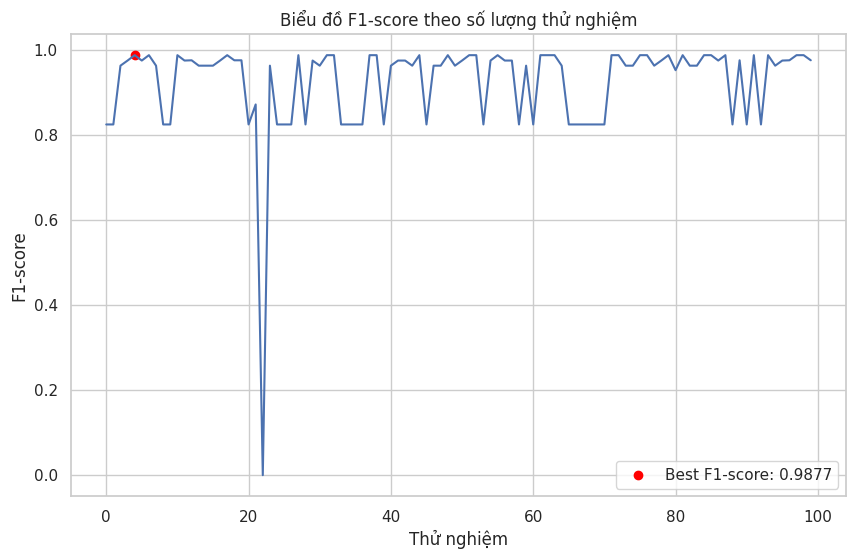

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Thu thập kết quả F1-score từ mỗi thử nghiệm
f1_scores = []
best_f1 = None
best_trial = None
for trial in study.trials:
    f1 = trial.value
    f1_scores.append(f1)
    if best_f1 is None or f1 > best_f1:
        best_f1 = f1
        best_trial = trial

# Vẽ biểu đồ F1-score
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(f1_scores)), y=f1_scores)
plt.xlabel("Thử nghiệm")
plt.ylabel("F1-score")
plt.title("Biểu đồ F1-score theo số lượng thử nghiệm")

# Đánh dấu vị trí F1-score tốt nhất
if best_trial is not None:
    best_trial_idx = best_trial.number
    plt.scatter([best_trial_idx], [best_f1], color='red', label=f'Best F1-score: {best_f1:.4f}')
    plt.legend()

plt.show()

## Traning good model 

In [7]:
# Lấy các tham số tối ưu từ kết quả tối ưu hóa
best_params = study.best_params

# Tạo mô hình XGBoost với các tham số tối ưu và huấn luyện trên toàn bộ tập huấn luyện
optimal_model = xgb.XGBClassifier(**best_params, random_state=42)
optimal_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.2741561403755381, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None,
              gamma=1.2676633674958187e-07, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1072829131562952, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=351, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [8]:
# Dự đoán trên tập kiểm tra
y_pred = optimal_model.predict(X_test)

# Đánh giá mô hình sử dụng F1-score
f1 = f1_score(y_test, y_pred)
print("F1-score trên tập kiểm tra của mô hình tái tạo:", f1)

F1-score trên tập kiểm tra của mô hình tái tạo: 0.9876543209876543
